In this notebook, we would like to introduce Imported and Computed tables that allow automatic processing.
We are using a simple calcium imaging pipeline as an example.

# Import the module that defines the upstream tables

To set up a simple calcium imaging data pipeline, we will extend the previous pipeline created in notebook 01. Let's first import a pre-prepared module that contains the table definition.

In [2]:
import experiment

Take a quick look at the tables Mouse and Session

In [3]:
experiment.Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
1,2020-01-06,M,
2,2019-08-23,M,
3,2020-01-22,F,


In [4]:
experiment.Session()

mouse_id Unique animal ID,session_number session number,session_date date,person researcher name,data_path file path for TIFF stacks
0,1,2019-12-03,Shan,data
1,1,2020-03-02,Thinh,data


# Define table `Scan` for meta information of each calcium imaging scan

Now let's define a table Scan that describe a scanning in an experimental session that stores the meta information of a particular scan.

In [6]:
import datajoint as dj

# still using the same schema
schema = dj.schema('shan_calcium')

@schema
class Scan(dj.Manual):
    definition = """
    -> experiment.Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

This table is dependent on the table `experiment.Session`, inheriting its primary key attributes, with an additional primary key attribute `scan_idx`. One session could contain multiple scans, which is another example of one-to-many relationship. We could take a look at the ERD again.

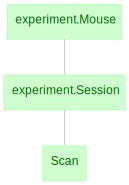

In [15]:
dj.ERD(experiment) + Scan

The `____` indicates additional primary key attributes apart from the ones inherited from its parents.

Here we have two tif files of scanning in the `data` folder `example_scan_01.tif` and `example_scan_02.tif` 

Let's insert these meta information manually.

In [14]:
Scan.insert([
    {'mouse_id': 0, 'session_number': 1, 'scan_idx': 1, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 'file_name': 'example_scan_01.tif'},
    {'mouse_id': 0, 'session_number': 1, 'scan_idx': 2, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 'file_name': 'example_scan_02.tif'},
])

In [23]:
Scan()

mouse_id Unique animal ID,session_number session number,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,1,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,1,2,200.0,920.0,24.0,15.0,example_scan_02.tif


# Explore one dataset and perform the segmentation

Now let's perform the segmentation to isolate regions of interest (ROIs). 

Let's first load one raw data and take a look:

In [16]:
from skimage import io
im = io.imread('data/example_scan_01.tif')
print(im.shape)

(100, 128, 128)


This tiff file contains 100 frames. Let's take a quick look at the average frame across time.

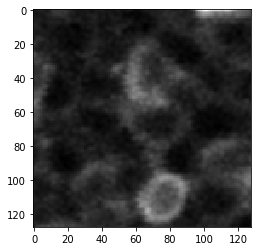

In [19]:
import numpy as np
import matplotlib.pyplot as plt
f = np.mean(im, axis=0)
plt.imshow(f, cmap=plt.cm.gray) 

Now let's detect the cells by setting up the threshold

In [3]:
mask = f > 50

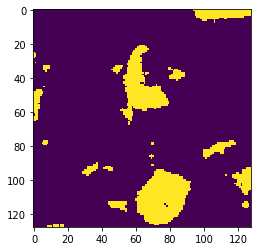

In [4]:
plt.imshow(mask)

Now we could use scipy.ndimage to detect the blobs from this binary mask

For the detailed tutorial, please refer to https://scipy-lectures.org/advanced/image_processing/index.html#segmentation

In [22]:
from scipy import ndimage

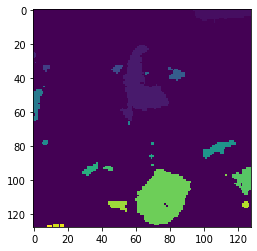

In [52]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im) 

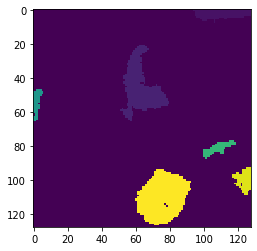

In [53]:
# filter out smaller blobs
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
mask_size = sizes < 50
remove_pixel = mask_size[label_im]

label_im[remove_pixel] = 0
plt.imshow(label_im)

In [58]:
# separate out each mask.
rois = []
for i in np.unique(label_im)[1:]:
    rois.append(label_im == i)

Let's take a look at an example of the mask

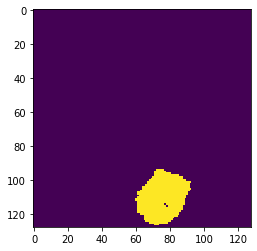

In [69]:
plt.imshow(rois[5])

# Imported table and Part table

Now let create an `Imported` table that perform these processing and saved the results, in this case, the segmented mask.

In [32]:
import os
@schema
class Segmentation(dj.Imported):
    definition = """
    -> Scan
    ---
    segmented_masks         : longblob   # overview of segmented masks
    average_fluorescence    : longblob   # average fluorescence across frames
    """
    def make(self, key): # key is one primary key of the entries in table Scan
        
        # fetch data directory from table Session
        data_path = (experiment.Session & key).fetch1('data_path')
        
        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1('file_name')
        
        # perform the same segmentation algorithm as we did before
        im = io.imread(os.path.join(data_path, file_name))
        f = np.mean(im, axis=0)
        mask = f > 50
        label_im, nb_labels = ndimage.label(mask)
        sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
        mask_size = sizes < 50
        remove_pixel = mask_size[label_im]
        label_im[remove_pixel] = 0
        rois = [dict(**key, roi_idx=i, mask=label_im==label) for i, label in enumerate(np.unique(label_im)[1:])]
        
        self.insert1(
            dict(**key, segmented_masks=label_im, average_fluorescence=f)
        )
        self.Roi.insert(rois)
        
    class Roi(dj.Part):
        definition = """
        -> master
        roi_idx             : int        # index of an roi
        ---
        mask                : longblob   # mask of this roi
        """

Let's clarify several conceptions:  
- Imported table: The table `Segmentation` is defined similarly as the previous tables we defined. The only difference is that this table is a **imported** table, which inherits from the datajoint class `dj.Imported`. There are two major features  An imported table allows for definition of computation for a single dataset and indicates that the computation relies on external data files, in this case the tiff files. 
>- `make` function: the computation was defined in the `make` function. It takes one primary key from the parent table `Scan` as an argument `key`, and perform the downstream computation. Eventually, construct the dictionary that contains all the fields in the current table and insert the entry with `insert1()` or `insert()`. The make function is called by the `populate` method
- Part table: The table `Roi` is a **part** table of the `Segmentation` table. In the definition, you could see that it inherits the primary from its master table `Segmentation` and have an extra primary key attribute `roi_idx`. The secondary attribute is the mask of a particular ROI. The master table drives the computation and the results in smaller granularies are saved in the part table. The benefit is to only load the tiff file once and get all segmentations ingested. The part table is not necessary if no results of smaller granularies are saved.

The `make` function is called by the populate method like this:

In [34]:
Segmentation.populate(display_progress=True)

100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


The `populate` does two things: